# Best Model (Logistic Regression) Analysis

## Loading data, Preprocessing and Training best model

In [ ]:
# Installing pyspark
!pip install pyspark
import pyspark.sql.functions as f
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Multiclass Classification').getOrCreate()
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [15]:
# Loading data and preprocessing
df = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/customer/Train.csv')
num_cols = []
binary_cols = ['Ever_Married', 'Gender', 'Graduated']
multi_cat_cols = ['Profession', 'Spending_Score', 'Var_1']
for cols in df.dtypes:
    if cols[1] != 'string' and cols[0] != 'ID':
        num_cols.append(cols[0])
print('Numerical Columns are:',*num_cols)
print('Binary categorical columns are:',*binary_cols)
print('Multilabel categorical columns are:',*multi_cat_cols)

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Imputer
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline

ind_b_cols = [i+"_ind_b" for i in binary_cols]
ind_m_cols = [i+"_ind_m" for i in multi_cat_cols]
ohe_op_cols = [i+"_ohe" for i in multi_cat_cols]

# Imputing missing values in numerical columns using median strategy
num_imputer = Imputer(strategy='median',inputCols=num_cols, outputCols=num_cols)

# String Indexing all string / categorical columns
indexer = StringIndexer(inputCols= binary_cols+multi_cat_cols, outputCols=ind_b_cols+ind_m_cols, stringOrderType='alphabetAsc', handleInvalid ='keep')

# String Indexing Segmentation (label) column
label_index = StringIndexer(inputCol='Segmentation', outputCol='label',stringOrderType='alphabetAsc', handleInvalid='skip')

# One Hot encoding multi label categorical columns
encoder = OneHotEncoder(inputCols = ind_m_cols, outputCols = ohe_op_cols, dropLast = False)

# Vector assembling all columns into a 'feature' vector
assembler = VectorAssembler(inputCols = ind_b_cols+ohe_op_cols+num_cols, outputCol="features")

# Creating a pipeline for all preprocessing steps
ohe_pipe = Pipeline(stages=[num_imputer, indexer, encoder,label_index, assembler])
pipe_model = ohe_pipe.fit(df)
processed_data = pipe_model.transform(df)

Numerical Columns are: Age Work_Experience Family_Size
Binary categorical columns are: Ever_Married Gender Graduated
Multilabel categorical columns are: Profession Spending_Score Var_1


In [17]:
# Training with the best model parameters that we found in Hyper Parameter tuning

from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(regParam=0, maxIter=15)
lrModel = lr.fit(processed_data)
predictions = lrModel.transform(processed_data)

## Objective Function Plot

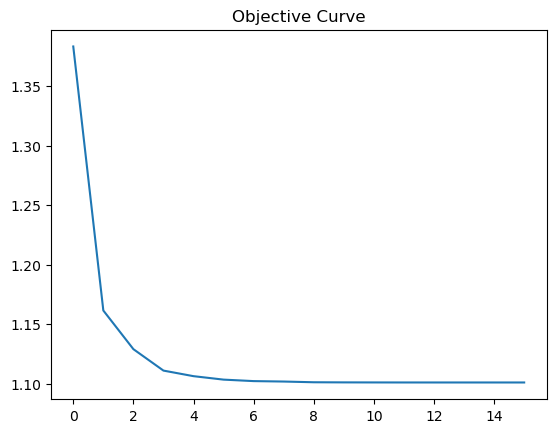

In [8]:

sns.lineplot(y=lrModel.summary.objectiveHistory, x=np.arange(lrModel.summary.totalIterations+1)).set_title('Objective Curve')
plt.show()

## Model Metrics

In [18]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
acc = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"}) 
tpr = evaluator.evaluate(predictions, {evaluator.metricName: "weightedTruePositiveRate"}) 
fpr = evaluator.evaluate(predictions, {evaluator.metricName: "weightedFalsePositiveRate"}) 
print('Below are the Model metrics:')
print('Accuracy: ', acc)
print('F1 Score: ', f1)
print('Precision: ', precision)
print('Recall: ', recall)
print('True Positive Rate: ', tpr)
print('Flase Positive Rate: ', fpr)

Below are the Model metrics:
Accuracy:  0.5163609320773426
F1 Score:  0.5028338582903934
Precision:  0.5042723456882228
Recall:  0.5163609320773426
True Positive Rate:  0.5163609320773426
Flase Positive Rate:  0.16178719053303553


- Model metrics are close to 0.5  
- Model accuracy is low, because the features were not that good
- Only 2 features (Age, Profession) have good predictive power
- Additional features need to be added or feature engineering to be done to enhance model performance

## Confusion Matrix

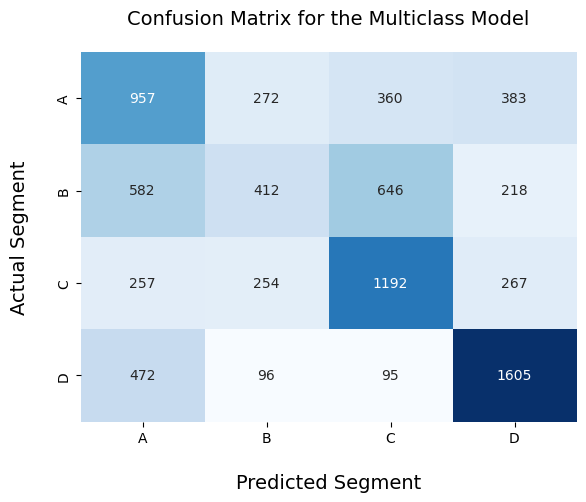

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_act = np.array(predictions.select("label").collect()).reshape(-1)
y_pred = np.array(predictions.select("prediction").collect()).reshape(-1)
cm = confusion_matrix(y_act, y_pred)

ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Segment", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['A', 'B', 'C','D'])

# set y-axis label and ticks
ax.set_ylabel("Actual Segment", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['A', 'B', 'C','D'])

# set plot title
ax.set_title("Confusion Matrix for the Multiclass Model", fontsize=14, pad=20)
plt.show()

#### Observations:
- 'D' and 'C' has most true positives
- It was observed from EDA on :
    - Age (D has young customers)  
    - Profession (C has most Artists, D has most healthCare)  
    - Spending Score (D and A has low spending score)
    - Graduated (D and A has non graduated customers)


## Feature Importance

Code for Feature_importance() is taken from [xinyongtian](https://github.com/xinyongtian/py_spark_ml_utils.git)  
I have modified the code to support multiclass classification

In [11]:
import pandas as pd
def extract_feature_name(dataframe,featuresVector,stat=False):
    from itertools import chain
    try:
        attrs = sorted(
            (attr["idx"], attr["name"]) for attr in (chain(*dataframe
                .schema[featuresVector]
                .metadata["ml_attr"]["attrs"].values()))) 
    except Exception as ex:
        print(f""""error occur in extract_feature_name(), it looks like column {featuresVector} does not have such metadata.
        error type:  {type(ex).__name__} , error message: {ex.args}
        error handled by   fill the feature name with index""")
        vectorsize=dataframe.rdd.collect()[0][featuresVector].size
        attrs=zip(list(range(vectorsize)),list(range(vectorsize)))
    df=pd.DataFrame(attrs,columns=['feature_index','feature_name'])
    if stat:
        from pyspark.ml.feature import StandardScaler
        standardScaler = StandardScaler(inputCol=featuresVector, outputCol="scaled")
        smodel = standardScaler.fit(dataframe)
        df['N']=dataframe.count()
        df['mean']=smodel.mean.toArray()
        df['std']=smodel.std.toArray()
    return df
def feature_importance(lrm_model,trainDF,trainFeatures,nonzero_only=True):
    coef=extract_feature_name(trainDF,trainFeatures,stat=True)
    cols = []
    for label_class in range(len(lrModel.coefficientMatrix.toArray())):
        coef[f'coef_{label_class}']=np.abs(lrm_model.coefficientMatrix.toArray()[label_class])
        cols.append(f'coef_{label_class}')
    coef['coef'] = coef[cols].mean(axis=1)
    coef["std_coef"]=coef["coef"]*coef["std"]
    coef["feature_importance"]=coef.std_coef.abs() 
    if nonzero_only:
        coef=coef.loc[coef.coef!=0,:]    
    coef.sort_values(by=["feature_importance"],ascending=False,inplace=True)
    coef.reset_index(drop=True,inplace=True)
    coef=coef[['feature_index', 'feature_name','coef',  'mean', 'std',  'std_coef', 'feature_importance']]
    return coef

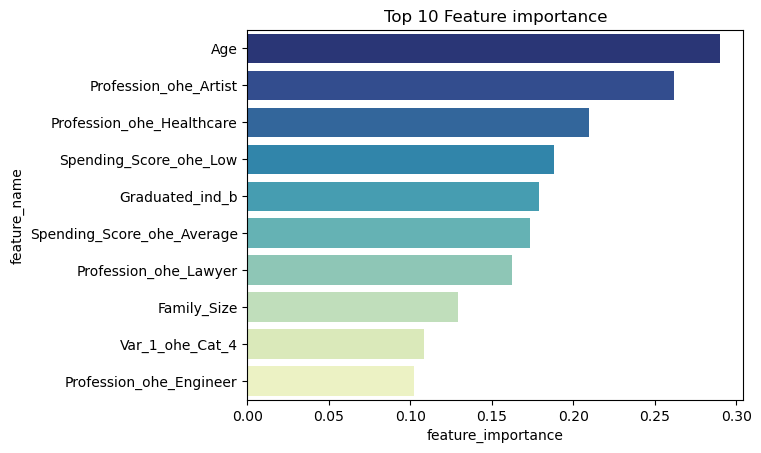

In [21]:
# Plotting top 10 feature importances 
FI = feature_importance(lrModel,predictions,'features',nonzero_only=False).head(10)
sns.barplot(data=FI, y='feature_name',x='feature_importance', palette='YlGnBu_r').set_title('Top 10 Feature importance')
plt.show()

## Tree plot of numeric features

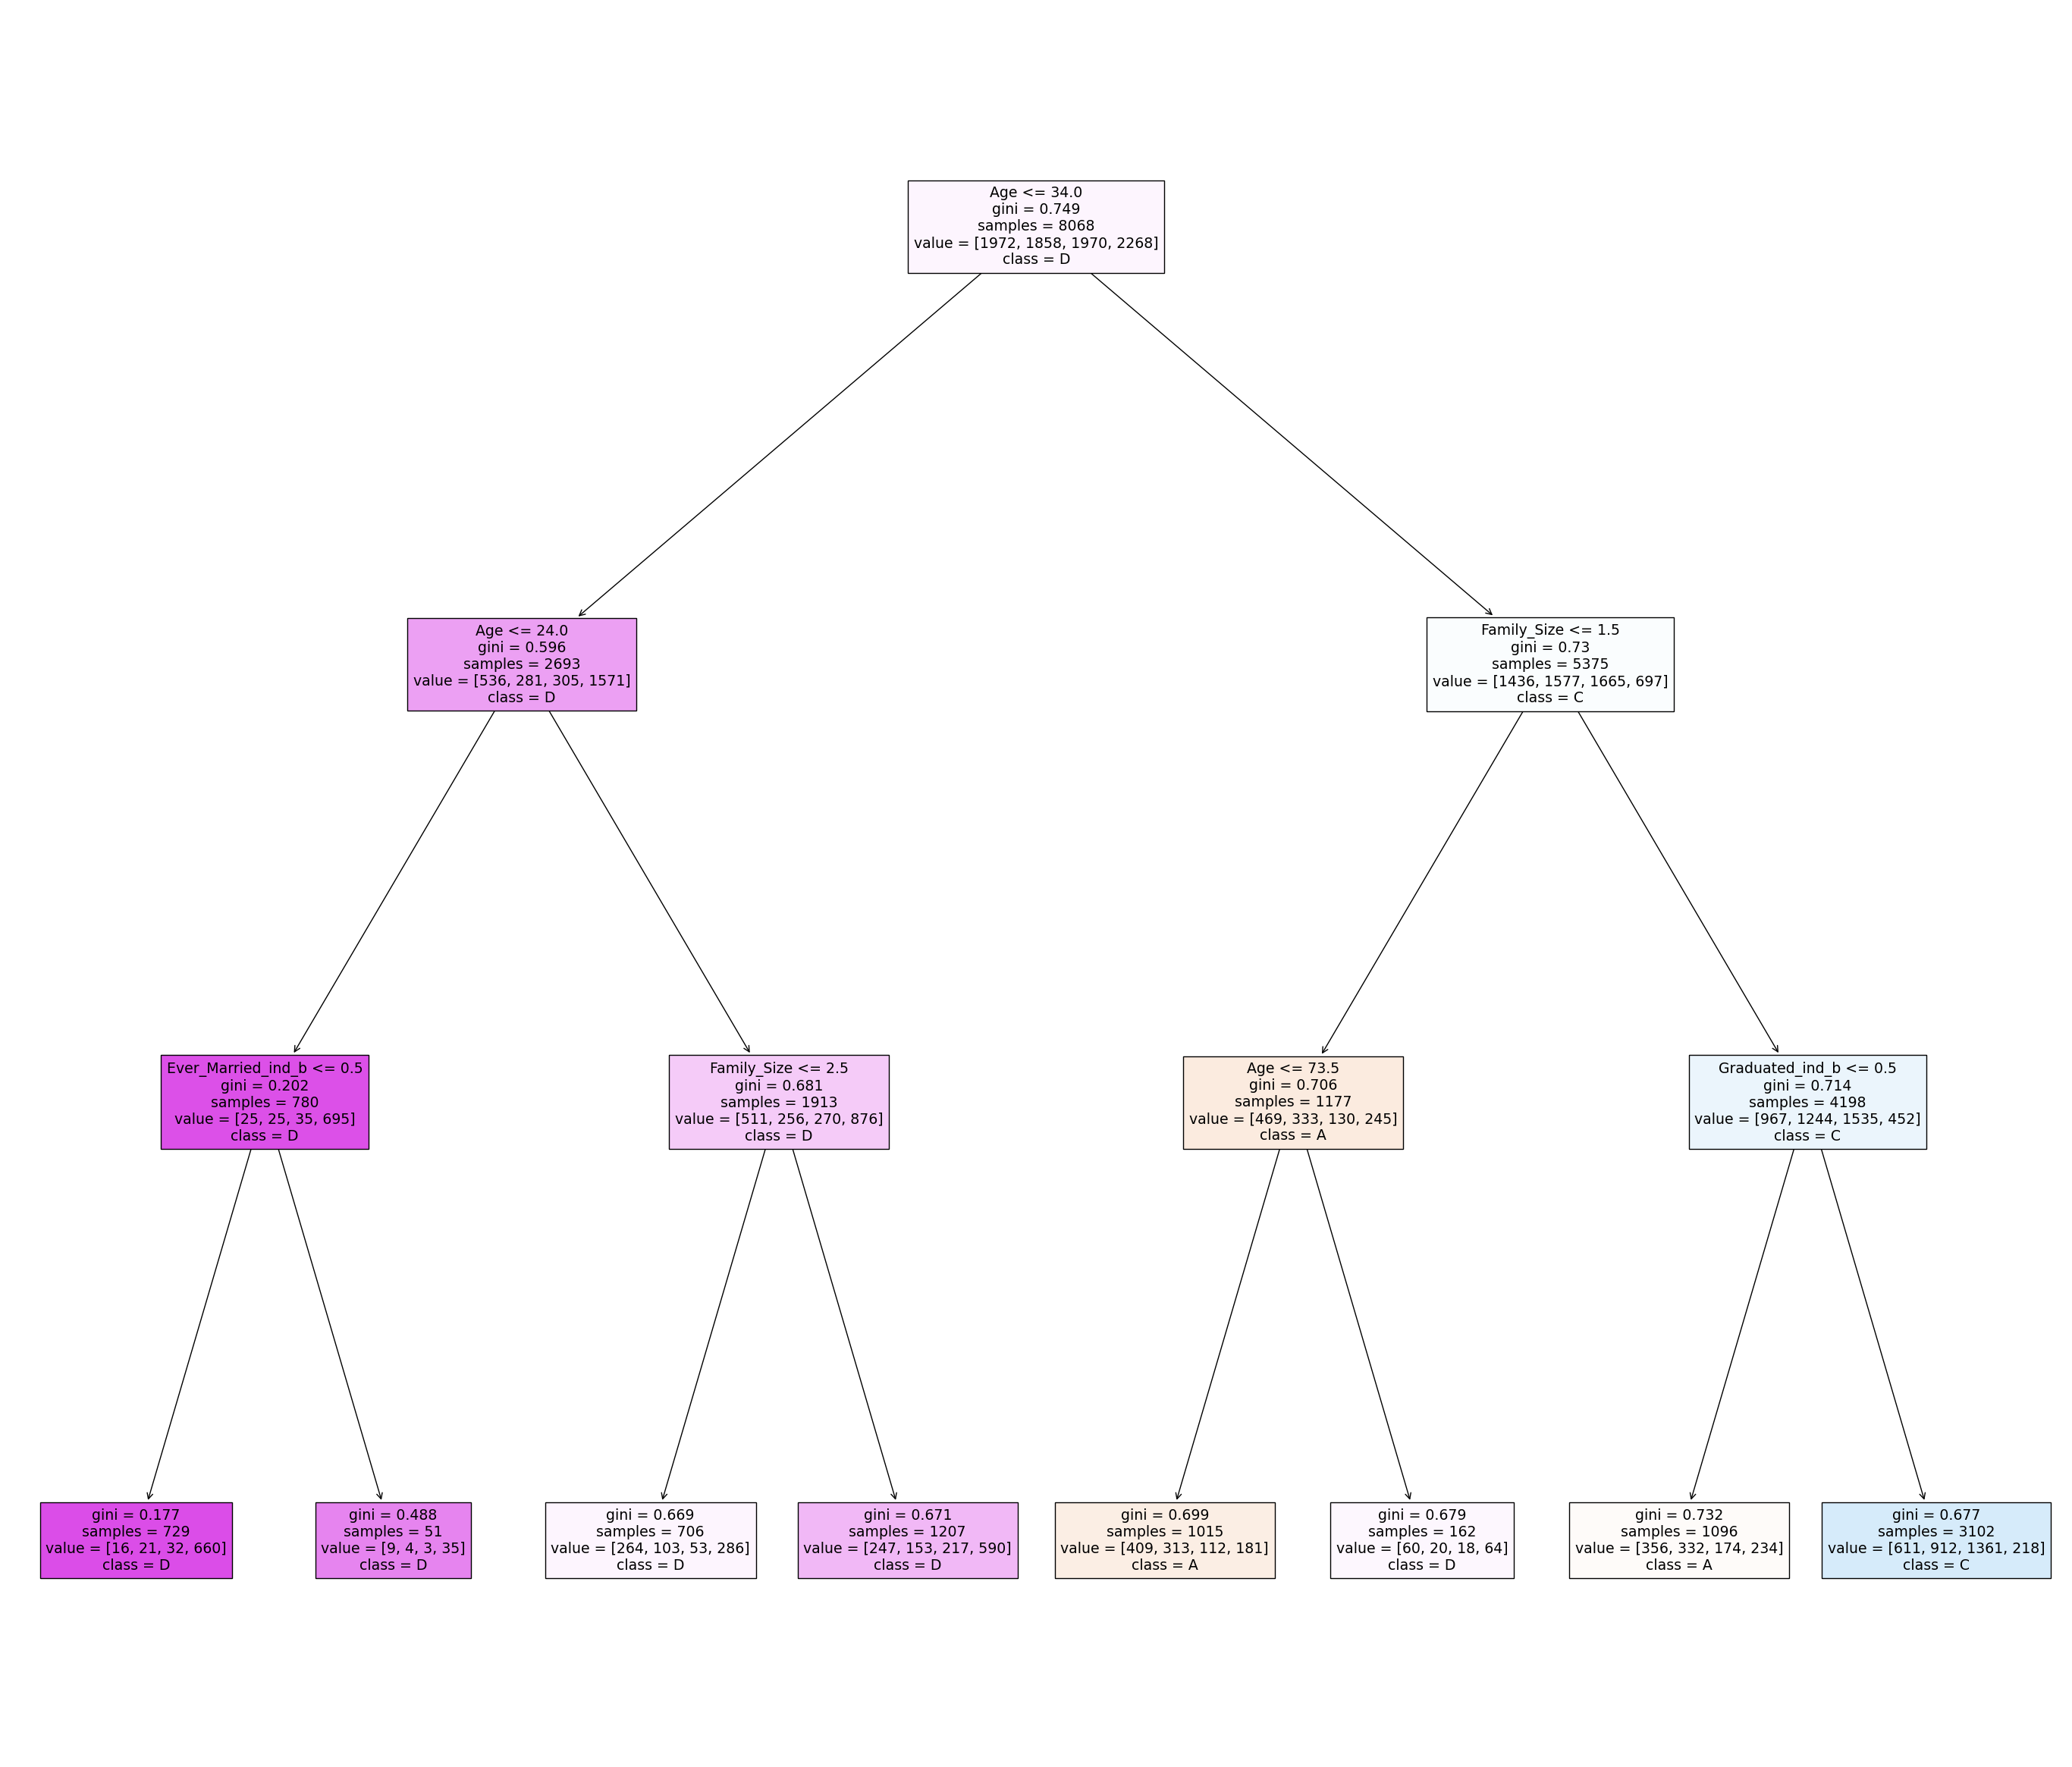

In [19]:

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
dataset = processed_data.toPandas()
features_col = num_cols+ind_b_cols
X = dataset[features_col].values
y = dataset['label'].values
dtc = DecisionTreeClassifier(max_depth=3)

fig = plt.figure(figsize=(35,30))
tree_model = dtc.fit(X,y)
_ = tree.plot_tree(dtc,
                  feature_names=features_col,
                  class_names=['A','B','C','D'],
                  filled=True)